In [1]:
import keras_ocr
import matplotlib.pyplot as plt
import numpy as np

---

In [26]:
IMG_PATH = 'test2.jpg'
pipeline = keras_ocr.pipeline.Pipeline()
# Read in image path
read_image = keras_ocr.tools.read(IMG_PATH)
# prediction_groups is a list of (word, box) tuples
prediction_groups = pipeline.recognize([read_image])
print(prediction_groups[0])

Looking for C:\Users\Joel\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Joel\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
[('pick', array([[250.,  73.],
       [354.,  73.],
       [354., 109.],
       [250., 109.]], dtype=float32)), ('y', array([[181.,  98.],
       [205.,  98.],
       [205., 137.],
       [181., 137.]], dtype=float32)), ('owfavourites', array([[198.89996, 113.38527],
       [425.9547 , 111.92978],
       [426.1383 , 140.56963],
       [199.08356, 142.02512]], dtype=float32)), ('to', array([[143.82675, 257.94348],
       [211.21902, 268.15442],
       [204.55835, 312.11493],
       [137.16608, 301.904  ]], dtype=float32)), ('curl', array([[224.10242, 269.82486],
       [355.14844, 290.73648],
       [348.078  , 335.0444 ],
       [217.03198, 314.13278]], dtype=float32)), ('or', array([[279.61508, 340.77438],
       [344.85843, 345.12393],
       [342.30978, 383.35403],
       [277.06644, 379.0045 ]], dtype=float32)), ('not', array([

---

In [27]:
for item in prediction_groups[0]:
    text = item[0]
    array = item[1]
    upperleft = array[0]
    bottomright = array[2]
    print(text, upperleft, bottomright)

pick [250.  73.] [354. 109.]
y [181.  98.] [205. 137.]
owfavourites [198.89996 113.38527] [426.1383  140.56963]
to [143.82675 257.94348] [204.55835 312.11493]
curl [224.10242 269.82486] [348.078  335.0444]
or [279.61508 340.77438] [342.30978 383.35403]
not [ 89.61998 374.66003] [161.52 420.36]
to [173.35385 389.1693 ] [220.61539 430.07703]
curly [233.18    398.74005] [342.62    448.66003]
takeout [231.11194 686.0182 ] [369.8954  725.13696]


In [34]:
def calcBox(item):
    res = {}
    res['content'] = item[0]
    res['category'] = 'text'

    coords = item[1]
    vec_a, vec_b, vec_d, vec_c = coords
    print(vec_a, vec_b, vec_c, vec_d)
    ab = vec_b - vec_a
    print('ab:', ab)
    ab_nor = ab / np.linalg.norm(ab)
    dc = vec_c - vec_d

    if np.linalg.norm(dc) > np.linalg.norm(ab):
        pass

    k_ab = ab[1] / ab[0]
    print('k_ab:', k_ab)
    angle = np.arctan(k_ab) / np.pi * 180
    print('angle:', angle)

    upperleft = vec_a
    ca = vec_a - vec_c
    print('ca', ca, 'norm', np.linalg.norm(ca))
    t_c = ca.dot(ab_nor)
    print('t_c', t_c)
    cp = ab_nor * t_c
    print('cp', cp)
    if np.cross(cp, ca) > 0:
        upperleft = vec_a - cp
    print('upperleft:', upperleft, '; a:', vec_a)

    upperright = vec_b
    db = vec_b - vec_d
    t_d = db.dot(ab_nor)
    print('t_d', t_d)
    dp = ab_nor * t_d
    print('dp', dp)
    if np.cross(db, dp) > 0:
        upperright = vec_b - dp
    print('upperright:', upperright, '; b:', vec_b)
    print('ab', upperright - upperleft)
    width = np.linalg.norm(upperright - upperleft)

    bp = dp - db
    ap = cp - ca
    print('ap:', ap, '; bp:', bp)
    height = max(np.linalg.norm(ap), np.linalg.norm(bp))

    res['left'] = np.array2string(upperleft[0], precision=6) 
    res['top'] = np.array2string(upperleft[1], precision=6) 
    res['width'] = np.array2string(width, precision=6) 
    res['height'] = np.array2string(height, precision=6) 
    res['angle'] = np.array2string(angle, precision=6) 
    return res

# print(calcBox(prediction_groups[0][0]))
calcBox(prediction_groups[0][4])

[224.10242 269.82486] [355.14844 290.73648] [217.03198 314.13278] [348.078  335.0444]
ab: [131.04602   20.911621]
k_ab: 0.15957464
angle: 9.0665126325854
ca [  7.0704346 -44.307922 ] norm 44.868507
t_c 1.3828278e-05
cp [1.3655508e-05 2.1790729e-06]
upperleft: [224.10242 269.82486] ; a: [224.10242 269.82486]
t_d 1.3828278e-05
dp [1.3655508e-05 2.1790729e-06]
upperright: [355.14844 290.73648] ; b: [355.14844 290.73648]
ab [131.04602   20.911621]
ap: [-7.0704207 44.307926 ] ; bp: [-7.0704207 44.307926 ]


{'content': 'curl',
 'category': 'text',
 'left': '224.10242',
 'top': '269.82486',
 'width': '132.70401',
 'height': '44.86851',
 'angle': '0.15824'}

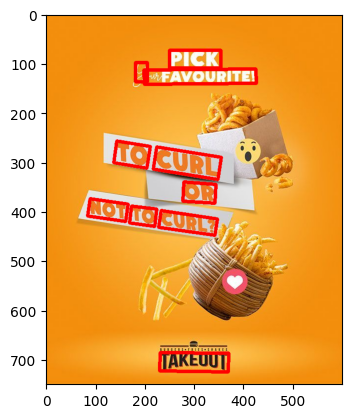

In [29]:
fig, axs = plt.subplots()
processed_image = keras_ocr.tools.drawBoxes(image=read_image, boxes=prediction_groups[0], boxes_format="predictions")
axs.imshow(processed_image)
plt.show()

---

In [1]:
import numpy as np

def get_rotation_matrix(angle):
    angle_in_radians = np.deg2rad(angle)
    c, s = np.cos(angle_in_radians), np.sin(angle_in_radians)
    return np.array([[c, -s], [s, c]]), np.array([[c, s], [-s, c]])

def group_to_one(boxes):
    rotate_angle = None
    for box in boxes:
        box_angle = box['angle']
        if rotate_angle is None:
            rotate_angle = box_angle
            continue
        # if rotate_angle * box_angle < 0:
        #     rotate_angle = np.float64(0)
        #     break
        # rotate_angle = np.sign(rotate_angle) * min(abs(rotate_angle), abs(box_angle))
        rotate_angle = (rotate_angle + box_angle) / 2

    # rotate coords
    rotation_matrix, inverse_rotation_matrix = get_rotation_matrix(rotate_angle)
    min_x = np.inf
    min_y = np.inf
    max_x = -1
    max_y = -1
    for box in boxes:
        rotated_coords = [np.dot(rotation_matrix, coord) for coord in box['coords']]
        # print(rotated_coords)
        for coord in rotated_coords:
            min_x = min(min_x, coord[0])
            max_x = max(max_x, coord[0])
            min_y = min(min_y, coord[1])
            max_y = max(max_y, coord[1])
    # invert rotate
    new_box = {}
    new_box['angle'] = np.array2string(rotate_angle, precision=2)
    new_box['width'] = np.array2string(max_x - min_x, precision=2)
    new_box['height'] = np.array2string(max_y - min_y, precision=2)
    [new_x, new_y] = np.dot(inverse_rotation_matrix, np.array([min_x, min_y]))
    new_box['left'] = np.array2string(new_x, precision=2)
    new_box['top'] = np.array2string(new_y, precision=2)
    # new_box['content'] = ' '.join([box['content'] for box in boxes])
    # new_box['category'] = 'text'
    return new_box

boxes = [
    {
        'angle': 45,
        'width': 50,
        'height': 20,
        'top': 20,
        'left': 20
    },
    {
        'angle': 45,
        'width': 50,
        'height': 20,
        'top': 20,
        'left': 70
    }
]
print(group_to_one(boxes))

NameError: name 'np' is not defined

In [30]:
class Box:
    def __init__(self, tmp) -> None:
        self.text = tmp[0]
        self.position = tmp[1]
        self.__printtext = '({text}, {pos})'.format(text=self.text, pos=np.array2string(self.position))

    def __str__(self) -> str:
        return self.__printtext
    
    def __repr__(self) -> str:
        return self.__printtext

box_list = [Box(p) for p in prediction_groups[0]]
print(box_list)

[(pick, [[250.  73.]
 [354.  73.]
 [354. 109.]
 [250. 109.]]), (y, [[181.  98.]
 [205.  98.]
 [205. 137.]
 [181. 137.]]), (owfavourites, [[198.89996 113.38527]
 [425.9547  111.92978]
 [426.1383  140.56963]
 [199.08356 142.02512]]), (to, [[143.82675 257.94348]
 [211.21902 268.15442]
 [204.55835 312.11493]
 [137.16608 301.904  ]]), (curl, [[224.10242 269.82486]
 [355.14844 290.73648]
 [348.078   335.0444 ]
 [217.03198 314.13278]]), (or, [[279.61508 340.77438]
 [344.85843 345.12393]
 [342.30978 383.35403]
 [277.06644 379.0045 ]]), (not, [[ 89.61998 374.66003]
 [166.48    385.64   ]
 [161.52    420.36   ]
 [ 84.65999 409.38   ]]), (to, [[173.35385 389.1693 ]
 [224.92307 395.61548]
 [220.61539 430.07703]
 [169.04617 423.63086]]), (curly, [[233.18    398.74005]
 [347.41998 415.06006]
 [342.62    448.66003]
 [228.38    432.34003]]), (takeout, [[231.11194 686.0182 ]
 [370.2223  687.2174 ]
 [369.8954  725.13696]
 [230.78503 723.93774]])]
